# Case 2. Diabetic Retinopathy Analysis
Ville Seeste<br>
Last edited: 26.02.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

The objectives on this exercise is to use convolutional neural network to try to diagnose if the patient has Diabetic Retinopathy disease. 

In training the network I use pictures of eyes which have and don't have the disease.

## 2. Required libraries and global variables

In [28]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import keras
import keras.layers as layers
import keras.models as models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import VGG19
%matplotlib inline

# Training parameters
batch_size = 32
epochs = 50
steps_per_epoch = 32 
validation_steps = 16
image_height = 200
image_width = 150

## 3. Data description and preprocessing

Data augmentation is used to prevent overfitting. Validation dataset is not augmentated because you want to accurate validation. I also tried to use a bit larger pictures but my computer didn't like that at all.

In [17]:
train_dir = "case2_dataset/train"
validation_dir = "case2_dataset/validation"
test_dir = "case2_dataset/test" 

train_datagen = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for train dataset

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

# Generator for validation dataset

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

Found 1237 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


## 4. Modeling and compilation




My plan was to use pretrained convolutional network as base of my model, freeze it and train only self added dense network. 

I tried VGG16 and VGG19 models with imagenet weights and there where not much difference in the outcome between those two. (VGG16 has 16 layers and VGG19 has 19). I also tried different kind of dense networks but the accuracy was pretty much the same.

In [18]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(image_height, image_width, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 6, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1572992   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 21,597,505
Trainable params: 1,573,121
Non-trainable params: 20,024,384
_________________________________________________________________


In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

## 5. Training

When training the model I noticed that my computer doesn't use my GPU. Instead it uses CPU (and it was very time consuming). Im not sure why this is happening at this point but I guess that I migth have installed tensorflow cpu version instead of gpu version. 

In [20]:
t1 = time.time()
h = model.fit_generator(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      verbose = 1,
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps)
t2 = time.time()

h.history.update({'time_elapsed': t2 - t1})
print('Total elapsed time for training: {:.3f} minutes'.format((t2-t1)/60))

Epoch 1/50
32/32 [==============================] - 562s 18s/step - loss: 0.5967 - acc: 0.7070 - val_loss: 0.5799 - val_acc: 0.7092
Epoch 2/50
32/32 [==============================] - 572s 18s/step - loss: 0.5757 - acc: 0.7068 - val_loss: 0.5545 - val_acc: 0.7092
Epoch 3/50
32/32 [==============================] - 587s 18s/step - loss: 0.5317 - acc: 0.7295 - val_loss: 0.5624 - val_acc: 0.7171
Epoch 4/50
32/32 [==============================] - 537s 17s/step - loss: 0.5502 - acc: 0.7171 - val_loss: 0.5391 - val_acc: 0.7191
Epoch 5/50
32/32 [==============================] - 576s 18s/step - loss: 0.5231 - acc: 0.7401 - val_loss: 0.5535 - val_acc: 0.7115
Epoch 6/50
32/32 [==============================] - 539s 17s/step - loss: 0.5248 - acc: 0.7435 - val_loss: 0.5254 - val_acc: 0.7073
Epoch 7/50
32/32 [==============================] - 566s 18s/step - loss: 0.5162 - acc: 0.7480 - val_loss: 0.5310 - val_acc: 0.7289
Epoch 8/50
32/32 [==============================] - 560s 17s/step - loss: 0.

## 6. Validation

Around 10 epochs my model started to overfit a little bit. Model reached it's best accuracy very quickly. Also it was handy to save the model and the history for a later use. 

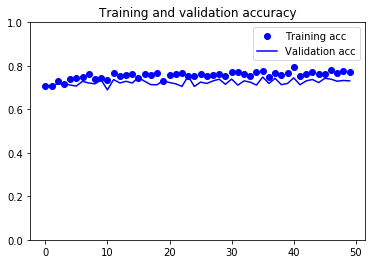

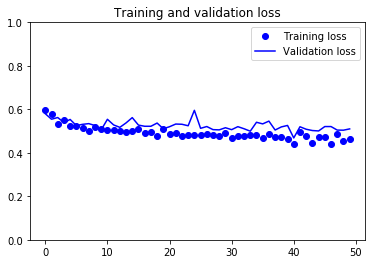

In [21]:
# Save model and history

model.save('case2run3.h5')
pickle.dump(h.history, open('history_run3.p', 'wb'))

# How to load
#h = pickle.load(open('history_run2.p', 'rb'))

acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylim([0, 1])
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0, 1])
plt.legend()

plt.show()

## 7. Results and Discussion

In [24]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height,image_width),
        batch_size = batch_size,
        class_mode = 'binary')

r = model.evaluate_generator(test_generator, steps = 32)

# Loss and accuracy
r

Found 413 images belonging to 2 classes.


[0.50467147808412205, 0.75736738697484807]

# Statistics

In [25]:
y_true = np.zeros(413)
y_score = np.zeros(413)
sample_count = 413
i = 0
for inputs_batch, labels_batch in test_generator:
        predicts_batch = model.predict(inputs_batch)
        L = labels_batch.shape[0]
        index = range(i, i + L)
        y_true[index] = labels_batch.ravel()
        y_score[index] = predicts_batch.ravel()
        i = i + L
        if i >= sample_count:
            break

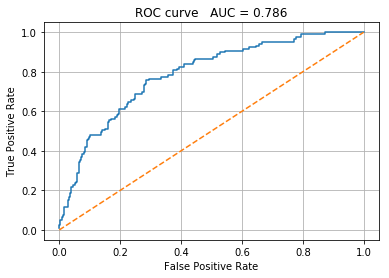

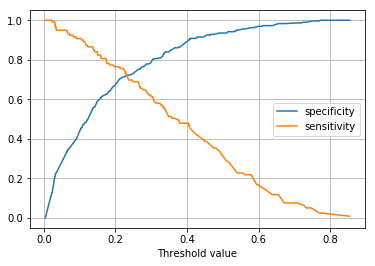

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve   AUC = {:.3f}'.format(auc))
plt.show()

plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [30]:
# Metrics

th = 0.3

acc = accuracy_score(y_true, y_score > th)
prec = precision_score(y_true, y_score > th)
f1 = f1_score(y_true, y_score > th)
recall = recall_score(y_true, y_score > th)

print('Accuracy:  {:.3f}'.format(acc))
print('Precision: {:.3f}'.format(prec))
print('Recall:    {:.3f}'.format(recall))
print('F1:        {:.3f}'.format(f1))
print('Classification report')
print(classification_report(y_true, y_score > th, labels = [1.0, 0.0], target_names = ['Disease', 'Healthy']))

Accuracy:  0.738
Precision: 0.541
Recall:    0.613
F1:        0.575
Classification report
             precision    recall  f1-score   support

    Disease       0.54      0.61      0.57       119
    Healthy       0.83      0.79      0.81       294

avg / total       0.75      0.74      0.74       413



In [31]:
# Confusion matrix

tn, fp, fn, tp = confusion_matrix(y_true, y_score > th).ravel()

print('                      Confusion matrix')
print('                       True condition')
print('                      Positive Negative      Sum')
print('Predicted | Positive  {:8} {:8} {:8}'.format(tp, fp, tp + fp))
print('condition | Negative  {:8} {:8} {:8}'.format(fn, tn, fn + tn))
print('                 Sum  {:8} {:8} {:8}'.format(tp + fn, fp + tn, tp + fp + fn + tn))
print(' ')
print('Sensitivity: {:.3f}'.format(tp/(tp+fn)))
print('Specificity: {:.3f}'.format(tn/(tn+fp)))

                      Confusion matrix
                       True condition
                      Positive Negative      Sum
Predicted | Positive        73       62      135
condition | Negative        46      232      278
                 Sum       119      294      413
 
Sensitivity: 0.613
Specificity: 0.789


I reached accuray of 75%. I expected to have better accuracy (at least 80%). Mayby with better image preprocessing, and unfreezing and fine-tuning couple last conv layers of the VGG model it would be possible. If you look at the confusion matrix you can see that model recognizes healty eyes correct the most.

## 8. Conclusions

I learned that convolutional networks perform well in image categorising problems. Pretrained models are good way of making models more accurate and learn faster. Also you don't have to try to make the model from scratch. 

I had some major difficulties running the training on my GPU and I need to fix that problem before case 3 (or use cloud services)